# Report 001
**original script:** D:\PRO-CODE\_CODE\dbahn\tasks\report_a_01

In [1]:
# Imports
import sys
import os
import urllib, base64
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import re

pd.options.display.max_colwidth = 50

In [2]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]

### Columns explanation
- TAA: Alerts (@@ separated)
- TA: Delay hour (before was in minutes) need to be compared with TIT column
- TIN: Train Model
- TIR: Route
- TSI: Station ID 
- TIM: Direction departura/arrival
- TIL: Request with parameters
- TIRE: Destination
- TIP: Platform number
- TIT: Departure hour
- TID: Date
- TSC: Station Name and ID 

# Extract

Creamos un nuevo DF con los trenes unicos por modelo:
- ruta
- minimo minutos registrado en retraso
- max minutos registrado en retraso

In [3]:
def loadFile( _datasetFolder, _dateFolder, _fileName ):
    fullPathFile = _datasetFolder + _dateFolder + '//' + _fileName
    df = pd.read_csv( fullPathFile, engine='python', quoting=3, skip_blank_lines=True,
                     sep=",", encoding ='utf-8', dtype={'TSI': 'object'} )
    return df.replace(np.nan, '', regex=True)

                      
def extractFct(group):
    delaysList = group['TAc'].unique().tolist()
    try:
        if len(delaysList)> 1:
            delaysList.remove(0)
    except: 
        pass
    
    result = pd.DataFrame([{
        'TIR': group['TIR'].unique(),
        'min_delay': np.min(delaysList),
        'max_delay': np.max(delaysList), 
    }], index=[0] ).T #}, index=[0] ).T
    return result

                      
def extractRouteDelays( _df, _regexp='', _direction='dep' ):
    dfG1 = _df[  _df['TIR'].str.contains(_regexp, regex=True) & _df['TIM'].str.match( _direction ) ]
    dfG2 = dfG1.groupby(['TIN'])[['TIN','TIR','TAc']].apply( extractFct )
    dfG2 = dfG2.unstack(level=-1)
    dfG2 = dfG2.reset_index()
    dfG2.columns = ['TIN','TIR','max_delay','min_delay']
    return dfG2

In [4]:
# Define the file directory
datasetFolder = 'D:/PRO-CODE/dbahn-report/data/master/note-log-cleaner_station-travels/'
dateFolder = '2017.08.27' #<<- CHANGE

In [5]:
dfKZraw = loadFile( datasetFolder, dateFolder, '8000206-17.08.27.csv') #<<- CHANGE
rx = 'Bonn Hbf [0-9:]+.*Köln Hbf [0-9:]*'
dfKZdelays = extractRouteDelays(dfKZraw, _regexp=rx)
dfKZdelays.head()

,TIN,TIR,max_delay,min_delay
0,EC 114,[Koblenz Hbf 19:00-Andernach 19:10-Bonn Hbf 19...,10,9
1,EC 6,[Koblenz Hbf 18:13-Bonn Hbf 18:44-Köln Hbf 19:...,0,0
2,EC 8,[Koblenz Hbf 16:13-Bonn Hbf 16:44-Köln Hbf 17:...,0,0
3,IC1920,[Koblenz Hbf 13:43-Andernach 13:54-Remagen 14:...,14,12
4,IC2004,[Koblenz Hbf 14:43-Andernach 14:54-Remagen 15:...,0,0


In [6]:
dfBNraw = loadFile( datasetFolder, dateFolder, '8000044-17.08.27.csv') #<<- CHANGE
rx = 'Bonn Hbf [0-9:]+.*Köln Hbf [0-9:]*'
dfBNdelays = extractRouteDelays(dfBNraw, _regexp=rx)
dfBNdelays.head()

,TIN,TIR,max_delay,min_delay
0,EC 6,[Bonn Hbf 18:46-Köln Hbf 19:05-Düsseldorf Hbf ...,0,0
1,EC 8,[Bonn Hbf 16:46-Köln Hbf 17:05-Düsseldorf Hbf ...,3,3
2,IC1920,[Bonn Hbf 14:23-Köln Hbf 14:42-Düsseldorf Hbf ...,0,0
3,IC2004,[Bonn Hbf 15:23-Köln Hbf 15:43-Düsseldorf Hbf ...,0,0
4,IC2012,[Bonn Hbf 16:23-Köln Hbf 16:43-Düsseldorf Hbf ...,0,0


In [7]:
dfKLraw = loadFile( datasetFolder, dateFolder, '8000207-17.08.27.csv') #<<- CHANGE
rx = 'Bonn Hbf [0-9:]+.*Köln Hbf [0-9:]*.*'
dfKLdelays = extractRouteDelays(dfKLraw, _regexp=rx, _direction='arr')
dfKLdelays.head()

,TIN,TIR,max_delay,min_delay
0,EC 8,[Karlsruhe Hbf 14:12-Mannheim Hbf 14:39-Mainz ...,0,0
1,IC1920,[Frankfurt(Main)Hbf 12:15-Frankfurt(M) Flughaf...,9,8
2,IC2004,[Karlsruhe Hbf (Halt entfällt) 12:21-Mannheim ...,0,0
3,IC2012,[Oberstdorf 09:48-Fischen 10:02-Sonthofen 10:1...,16,14
4,IC2216,[Stuttgart Hbf 07:37-Vaihingen(Enz) 07:55-Heid...,0,0


# Link Tables
After extract and filter the tables it´s necesaary to find a link between them.
It´s not enought to use the train identifier because there are in the day more travel with the same identifier.
The link will be a string that contains the destination-hour in the route.

```
[Koblenz Hbf 16:13-Bonn Hbf 16:44-Köln Hbf 17:05-Düsseldorf Hbf 17:30Duisburg Hbf 17:45-Essen Hbf 17:58-Gelsenkirchen Hbf 18:08-Hamburg-Harburg 21:02-Hamburg Dammtor 21:20-Hamburg-Altona 21:29, Koblenz Hbf 16:13-Bonn Hbf 16:44-Köln Hbf 17:05-Düsseldorf Hbf 17:30Essen Hbf 17:58-Gelsenkirchen Hbf 18:08-Münster(Westf)Hbf 18:54-Hamburg Hbf 21:14-Hamburg Dammtor 21:20-Hamburg-Altona 21:29, Koblenz Hbf 16:13-Bonn Hbf 16:44-Köln Hbf 17:05-Düsseldorf Hbf 17:30Essen Hbf 17:58-Osnabrück Hbf 19:22-Hamb...
```

```Köln Hbf 17:05```

In [8]:
def extractLink( row ):
    return re.search('(Köln Hbf [0-9:]*)', row['TIR'][0]).group(1)

dfKZdelays['link'] = dfKZdelays.apply( extractLink, axis=1)
dfBNdelays['link'] = dfBNdelays.apply( extractLink, axis=1)
dfKLdelays['link'] = dfKLdelays.apply( extractLink, axis=1)


In [9]:
listSuffixes = ['_kz','_bn']
dfM1 = pd.merge(dfKZdelays, dfBNdelays, on='link', suffixes=listSuffixes)
dfM2 = pd.merge(dfM1, dfKLdelays, on='link', suffixes=listSuffixes)

dfM2=dfM2.rename(columns = {
    'TIN':'TIN_kl',
    'TIR':'TIR_kl',
    'max_delay':'max_delay_kl',
    'min_delay':'min_delay_kl',
})
dfM2.head(3)


,TIN_kz,TIR_kz,max_delay_kz,min_delay_kz,link,TIN_bn,TIR_bn,max_delay_bn,min_delay_bn,TIN_kl,TIR_kl,max_delay_kl,min_delay_kl
0,EC 8,[Koblenz Hbf 16:13-Bonn Hbf 16:44-Köln Hbf 17:...,0,0,Köln Hbf 17:05,EC 8,[Bonn Hbf 16:46-Köln Hbf 17:05-Düsseldorf Hbf ...,3,3,EC 8,[Karlsruhe Hbf 14:12-Mannheim Hbf 14:39-Mainz ...,0,0
1,IC1920,[Koblenz Hbf 13:43-Andernach 13:54-Remagen 14:...,14,12,Köln Hbf 14:42,IC1920,[Bonn Hbf 14:23-Köln Hbf 14:42-Düsseldorf Hbf ...,0,0,IC1920,[Frankfurt(Main)Hbf 12:15-Frankfurt(M) Flughaf...,9,8
2,IC2004,[Koblenz Hbf 14:43-Andernach 14:54-Remagen 15:...,0,0,Köln Hbf 15:43,IC2004,[Bonn Hbf 15:23-Köln Hbf 15:43-Düsseldorf Hbf ...,0,0,IC2004,[Karlsruhe Hbf (Halt entfällt) 12:21-Mannheim ...,0,0


In [10]:
dfM2.columns.tolist()

['TIN_kz',
 'TIR_kz',
 'max_delay_kz',
 'min_delay_kz',
 'link',
 'TIN_bn',
 'TIR_bn',
 'max_delay_bn',
 'min_delay_bn',
 'TIN_kl',
 'TIR_kl',
 'max_delay_kl',
 'min_delay_kl']

## PLOT



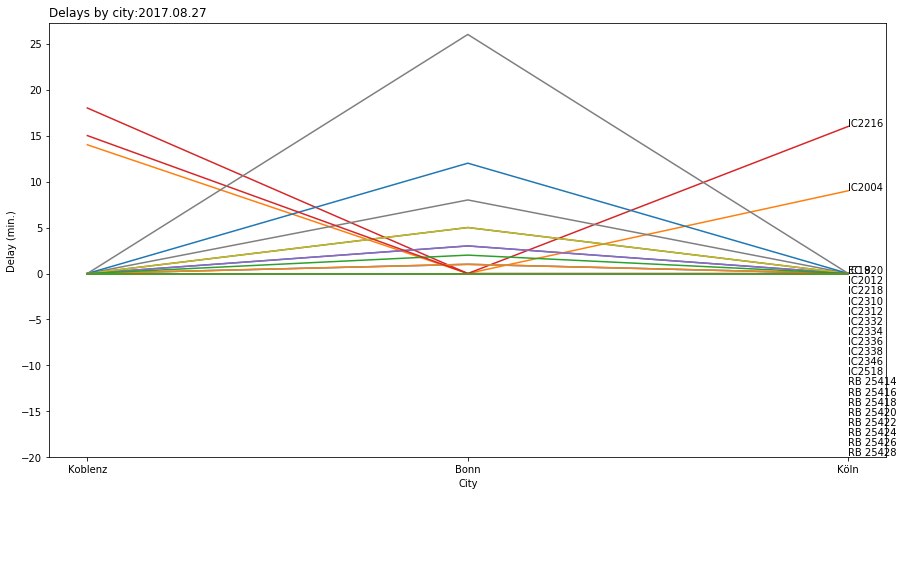

In [11]:
fig = plt.figure(figsize=(15,8))
plt.title('Delays by city:' + str(dateFolder),  loc='left', pad=None)
plt.xlabel( 'City' )
plt.ylabel( 'Delay (min.)' )

pos = []

def recursion( n ):
    if n in pos:
        p = n - 1.1  
        p = recursion( p )
    else:
        p = n
        pos.append( p )
    

for index, row in dfM2.iterrows():
    p = recursion( float(row['max_delay_kl']) )
    
    yfit = [
        row['max_delay_kz'],
        row['max_delay_bn'],
        row['max_delay_kl']
    ]
    xfit = ['Koblenz', 'Bonn', 'Köln']
    plt.plot( xfit, yfit, zorder=3 );
    plt.annotate( 
        row['TIN_kz'],
        xy=( 2, pos[index-1] )
       
    )
    
plt.yticks(np.arange(-20, 30, 5.0))

plotName = 'delays-by-city__' + str(dateFolder) 
plt.savefig( 'D:/PRO-CODE/dbahn-report/project/reports//' + plotName + '.png', dpi=125)

plt.show()